# Интеллектуальный анализ данных – весна 2025

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов.


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [2]:
k1 = 8/10
k2 = 2/10
res = -(k1*np.log2(k1) + k2*np.log2(k2))
print(f"Entropy: {res:.2f}")

Entropy: 0.72


**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [4]:
J = 2
R_m = 10
H_r_m = (k1*(1 - k1) + k2*(1 - k2))
R_l_m = 8/10
R_r_m = 2/10
H_r_l = 0
H_r_r = 0
print(H_r_m - R_l_m*H_r_l - R_r_m*H_r_r)


0.32


**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [5]:
temp = np.array([1, 10, 5, 18, 100, 30, 50, 61, 84, 47])
res = temp.sum()
print(res/temp.size)

40.6


## Часть 3: Бэггинг и случайный лес

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [6]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier

In [7]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

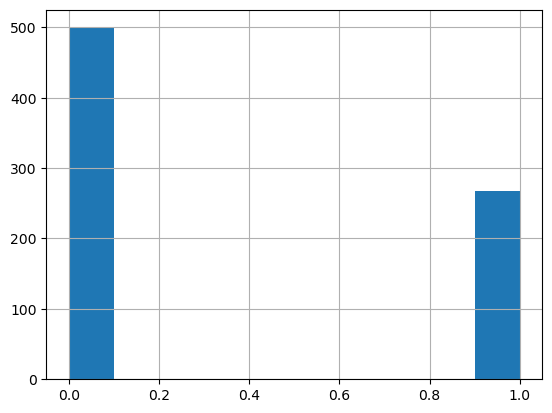

In [8]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [9]:
X = data.loc[:, 'Pregnancies':'Age']
X.head()
y = data['Outcome']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.7, stratify=y, random_state=42
)

X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(
    X_train, y_train, train_size=0.7, stratify=y_train, random_state=42
)

**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке. 


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [10]:
max_depth = [3,5,7]
min_samples_leaf = [1,3,5,10,15]
depth_best = 0
leaf_best = 0
f1_max = -10000000000000000
for i in max_depth:
    for j in min_samples_leaf:
        dt = DecisionTreeClassifier(max_depth=i, min_samples_leaf=j, random_state=42)
        dt.fit(X_train_train,y_train_train)
        res = dt.predict(X_train_val)
        f1 = f1_score(y_pred=res, y_true=y_train_val)
        if f1 > f1_max:  # ищем МАКСИМУМ
            f1_max = f1
            depth_best, leaf_best = i, j

full_dt = DecisionTreeClassifier(max_depth=depth_best, min_samples_leaf=leaf_best, random_state=42)
full_dt.fit(X_train, y_train)
full_y = full_dt.predict(X_test)
y_test_proba = full_dt.predict_proba(X_test)[:, 1]
acc = accuracy_score(y_pred=full_y, y_true=y_test)
prec = precision_score(y_pred=full_y, y_true=y_test)
rec = recall_score(y_pred=full_y, y_true=y_test)
ra = roc_auc_score(y_score=y_test_proba, y_true=y_test)
print("Accuracy: ", acc)
print("Precision: ", prec)
print("Recall: ", rec)
print("ROC-AUC: ", ra)

Accuracy:  0.7619047619047619
Precision:  0.7407407407407407
Recall:  0.49382716049382713
ROC-AUC:  0.7930864197530865


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [11]:
bg = BaggingClassifier(n_estimators=50)
bg.fit(X_train, y_train)
bg_y = bg.predict(X_test)
bg_y_proba = bg.predict_proba(X_test)[:, 1]
bg_acc = accuracy_score(y_pred=bg_y, y_true=y_test)
bg_prec = precision_score(y_pred=bg_y, y_true=y_test)
bg_rec = recall_score(y_pred=bg_y, y_true=y_test)
bg_ra = roc_auc_score(y_score=bg_y_proba, y_true=y_test)
print("Accuracy: ", bg_acc)
print("Precision: ", bg_prec)
print("Recall: ", bg_rec)
print("ROC-AUC: ", bg_ra)

Accuracy:  0.7662337662337663
Precision:  0.7213114754098361
Recall:  0.5432098765432098
ROC-AUC:  0.818065843621399


**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации. 
3. Выберите ту пару значений, которая даёт наилучшее среднее качество. 

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [12]:
max_depth = [3,5,7,9]
min_samples_leaf = [1,3,5,8,12,15,18]
best_f1 = -1
best_depth = 0
best_leaf = 0
for i in max_depth:
    for j in min_samples_leaf:
        rf = RandomForestClassifier(max_depth=i, min_samples_leaf=j, n_estimators=50, random_state=42)
        cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='f1', n_jobs=-1)
        mean_f1 = cv_scores.mean()
        if mean_f1 > best_f1:
            best_f1 = mean_f1
            best_depth, best_leaf = i,j
rf_best = RandomForestClassifier(max_depth=best_depth, min_samples_leaf=best_leaf, n_estimators=50,random_state=42)
rf_best.fit(X_train, y_train)
rf_y = rf_best.predict(X_test)
rf_y_proba = rf_best.predict_proba(X_test)[:, 1]
rf_acc = accuracy_score(y_pred=rf_y, y_true=y_test)
rf_prec = precision_score(y_pred=rf_y, y_true=y_test)
rf_rec = recall_score(y_pred=rf_y, y_true=y_test)
rf_ra = roc_auc_score(y_score=rf_y_proba, y_true=y_test)
print("Accuracy: ", rf_acc)
print("Precision: ", rf_prec)
print("Recall: ", rf_rec)
print("ROC-AUC: ", rf_ra) #обычный беггинг показал себя круче как по мне

Accuracy:  0.7489177489177489
Precision:  0.6885245901639344
Recall:  0.5185185185185185
ROC-AUC:  0.834238683127572


**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

C:\Users\Admin\AppData\Local\Temp\ipykernel_14740\4182009984.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


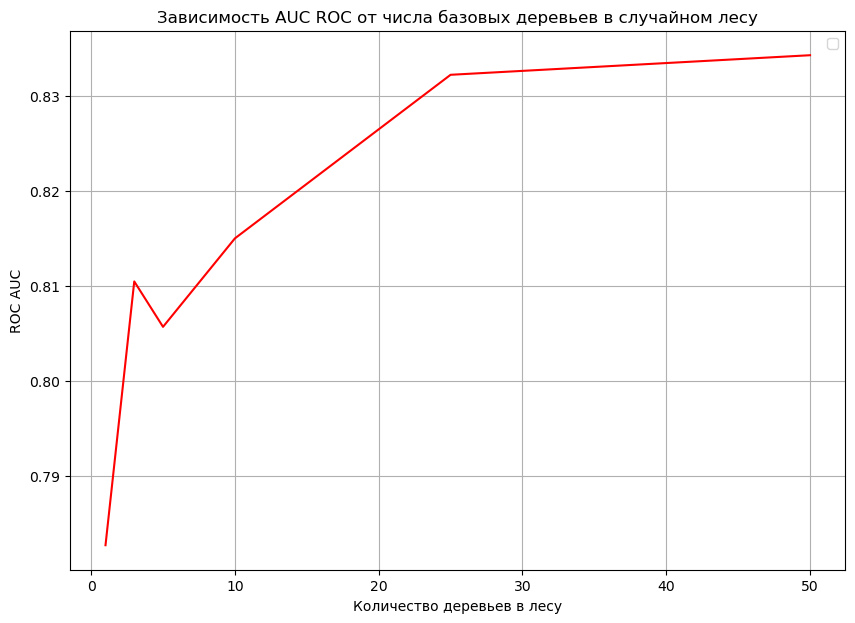

In [13]:
n = [1,3,5,10, 25,50]
res = []
for i in n:
    rf = RandomForestClassifier(max_depth=best_depth, min_samples_leaf=best_leaf,n_estimators=i, random_state=42)
    rf.fit(X_train,y_train)
    rf_y_proba = rf.predict_proba(X_test)[:, 1]
    rf_ra = roc_auc_score(y_score=rf_y_proba, y_true=y_test)
    res.append(rf_ra)
plt.figure(figsize=(10, 7))

plt.title("Зависимость AUC ROC от числа базовых деревьев в случайном лесу")
plt.plot(n, res, c="r")
plt.xlabel("Количество деревьев в лесу")
plt.ylabel("ROC AUC")
plt.grid()
plt.legend()


**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

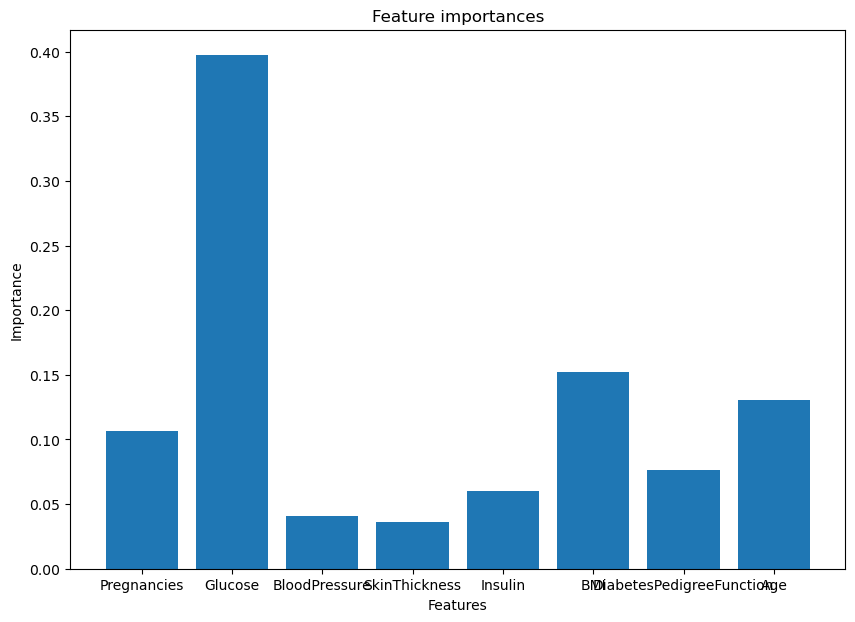

In [104]:


plt.figure(figsize=(10, 7))
plt.title("Feature importances")
plt.bar(X.columns , rf_best.feature_importances_)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()